# Purpose
to parse the text files from the new RFID system around the hut in wedge 4

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, glob, csv, sys

# User defined locations

In [8]:
listoffiles=[]
fld='/home/dennislab2/Desktop/burrowdata'
for folder in os.listdir(fld):
    if len(folder) > 2:
        folder_path = os.path.join(fld,folder)
        for file_name in os.listdir(folder_path):
            listoffiles.append(os.path.join(folder_path,file_name))
listoffiles.sort()
listoffiles[0:10]

['/home/dennislab2/Desktop/burrowdata/burrow5/000001023734-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000215252-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000008080032-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000074419-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000008015517-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000012636-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000008035815-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000003200638-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000007021029-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000003083151-DATA-0005.txt']

# Functions

In [112]:
def get_curt_data(folder_path):
    '''
    input a folder of txt files from a curt lamberth logger, and output a df with only tags\
    '''
    if not os.path.isdir(folder_path):
        print('you entered {} which is not a valid folder path')
    else:
        listoffiles=[]
        for file_name in os.listdir(folder_path):
            listoffiles.append(os.path.join(folder_path,file_name))
        listoffiles.sort()
        df=pd.DataFrame(columns=['datetime', 'LOGGER_ID', 'WIRELESS_ID', 'motion_det', 'tempC', 'hum%',
               'AMP1ADC', 'AMP2ADC', 'batV_L', 'batV_NL', 'int-tempC', 'Tag_ID',
               'Pdir', 'Err', 'ext-tempC', 'Line', 'Comment'])
        listoffiles = []
        for file in listoffiles:
            if 'config' not in file:
                print(file)
                txtascsv=pd.read_csv(file,sep=',',header=[1])
                if txtascsv.columns[0]=='datetime':
                    onlytags = txtascsv[(txtascsv.Tag_ID.astype(str) !='nan') & (txtascsv.Tag_ID.astype(str) !='-99.0')].reset_index(drop=True)
                    df=pd.concat([df,onlytags]).reset_index(drop=True)

        dt=df.datetime.str.split(' ',expand=True)
        dt.columns=['date','time']
        dt['relday']=dt.date.str.split('/',expand=True)[0].astype(int)
        dt['relmo']=dt.date.str.split('/',expand=True)[1].astype(int)
        dt[['hr','mins','sec']]=dt.time.str.split(':',expand=True).astype(int)
        if np.max(dt.relmo)!=0:
            for i in np.arange(0,len(np.unique(dt.relmo))-1):
                uniquemo=np.unique(dt.relmo)[i]
                maxday=np.max(dt.relday[dt.relmo==uniquemo])+1
                dt.relday[tst.relmo==np.unique(tst.relmo)[i+1]]+=maxday
        df['reltime_hrs']=(dt.relday*24)+(dt.hr)+(dt.mins/60)+(dt.sec/3600)
        return df

In [12]:
def get_txtfile_contents(txtfile):
    dates=[]
    first=[]
    second=[]
    third=[]
    tagvals=[]
    mvs=[]

    # import file
    f = open(txtfile, 'r') 
    for x in f.readlines():
        if "TAG" in x:
            values=[xval.split(' ') for xval in x.split(':')]
            dates.append(values[1][2])
            first.append(values[1][3])
            second.append(values[2][0])
            third.append(values[3][0])
            tagvals.append(values[3][1])
            mvs.append(values[3][2])

    # want this to be a dataframe
    df=pd.DataFrame({'dates':dates,'hour':first,'minute':second,'second':third,'tagvals':tagvals,'mvs':mvs})
    df['converted_tags'] = df.tagvals
    for i in np.arange(0,len(df.tagvals)):
        val=df.converted_tags[i]
        df.converted_tags[i]=int(val[4:],base=16)
    return df

# Exploration

In [5]:
has_run=1
if has_run == 0:
    x=-1
    for txtfile in listoffiles:
        x+=1
        if x==0:
            df_alldata = get_txtfile_contents(txtfile)
        else:
            df = get_txtfile_contents(txtfile)
            df_alldata = pd.concat([df_alldata,df],ignore_index=True)
        if x%10==0:
            print(x)
    df_alldata.to_csv('../data/2024_RFID_hut_data.csv')
else:
    df_alldata = pd.read_csv('../data/2024_RFID_hut_data.csv',index_col=0)

In [6]:
df_alldata

,dates,hour,minute,second,tagvals,mvs,converted_tags
0,6/16/2022,17,33,8.09,3E7.0000001D01,714,7425
1,6/16/2022,17,42,33.58,384.0A0301EAAF,498,43000130223
2,6/16/2022,17,42,33.61,384.0A0301EAAF,512,43000130223
3,6/16/2022,17,42,33.65,384.0A0301EAAF,502,43000130223
4,6/16/2022,17,42,33.68,384.0A0301EAAF,494,43000130223
...,...,...,...,...,...,...,...
87267,7/27/2022,6,24,41.13,3E7.0000001D01,739,7425
87268,7/27/2022,6,34,41.41,3E7.0000001D01,736,7425
87269,7/27/2022,6,44,41.20,3E7.0000001D01,734,7425
87270,7/27/2022,7,4,41.13,3E7.0000001D01,735,7425


In [7]:
unique_tags = np.unique(df_alldata.converted_tags)
unique_tags[1:]

array([43000130206, 43000130217, 43000130223, 43000130232, 43000130236,
       43000130250, 43000130258, 43000130280, 43000130282, 43000130291,
       43000130324, 43000130337, 43000130345, 43000130355, 43000130357,
       43000130359, 43000130399, 67000063703], dtype=int64)

In [8]:
# find the last date the animal was seen
for animal in unique_tags:
    subdf=df_alldata[df_alldata.converted_tags==animal]
    print(animal)
    print(list(subdf.dates)[-1])
    print('   ')

7425
7/27/2022
   
43000130206
6/17/2022
   
43000130217
6/16/2022
   
43000130223
6/26/2022
   
43000130232
7/26/2022
   
43000130236
6/17/2022
   
43000130250
7/26/2022
   
43000130258
6/16/2022
   
43000130280
6/22/2022
   
43000130282
6/17/2022
   
43000130291
7/27/2022
   
43000130324
7/26/2022
   
43000130337
7/26/2022
   
43000130345
7/26/2022
   
43000130355
7/26/2022
   
43000130357
6/16/2022
   
43000130359
6/16/2022
   
43000130399
7/26/2022
   
67000063703
7/26/2022
   


In [10]:
df_alldata = df_alldata[df_alldata.converted_tags != 7425] #removes test from system
df_alldata=df_alldata.reset_index().drop(columns='index')
df_alldata

,dates,hour,minute,second,tagvals,mvs,converted_tags
0,6/16/2022,17,42,33.58,384.0A0301EAAF,498,43000130223
1,6/16/2022,17,42,33.61,384.0A0301EAAF,512,43000130223
2,6/16/2022,17,42,33.65,384.0A0301EAAF,502,43000130223
3,6/16/2022,17,42,33.68,384.0A0301EAAF,494,43000130223
4,6/16/2022,17,42,33.71,384.0A0301EAAF,489,43000130223
...,...,...,...,...,...,...,...
82839,7/27/2022,4,29,23.43,384.0A0301EAF3,666,43000130291
82840,7/27/2022,4,29,23.46,384.0A0301EAF3,654,43000130291
82841,7/27/2022,4,29,23.49,384.0A0301EAF3,667,43000130291
82842,7/27/2022,4,29,23.52,384.0A0301EAF3,710,43000130291


In [11]:
np.unique(df_alldata.converted_tags)

array([43000130206, 43000130217, 43000130223, 43000130232, 43000130236,
       43000130250, 43000130258, 43000130280, 43000130282, 43000130291,
       43000130324, 43000130337, 43000130345, 43000130355, 43000130357,
       43000130359, 43000130399, 67000063703], dtype=int64)

In [102]:
df_old = pd.read_csv('../data/W4.CI.for.Emily.csv')
df_old

,Unnamed: 0,Timestamp,Reader,RFID,Mouse,Date,Hour,Minute,Second,Day,Wedge,Location
0,1,2022-07-28 03:53:00,wedge22,48 48 48 49 51 48 50 57 49,2043,2022-07-28,3,53,0,07-28,Wedge 4,Feeder
1,2,2022-07-28 02:34:49,wedge22,48 48 48 49 51 48 50 57 49,2043,2022-07-28,2,34,49,07-28,Wedge 4,Feeder
2,3,2022-07-28 02:13:57,wedge22,48 48 48 49 51 48 50 57 49,2043,2022-07-28,2,13,57,07-28,Wedge 4,Feeder
3,4,2022-07-28 02:13:52,wedge22,48 48 48 49 51 48 50 57 49,2043,2022-07-28,2,13,52,07-28,Wedge 4,Feeder
4,5,2022-07-28 02:13:42,wedge22,48 48 48 49 51 48 50 57 49,2043,2022-07-28,2,13,42,07-28,Wedge 4,Feeder
...,...,...,...,...,...,...,...,...,...,...,...,...
14422,14423,2022-06-16 17:52:17,wedge22,48 48 48 48 54 51 55 48 51,2021,2022-06-16,17,52,17,06-16,Wedge 4,Feeder
14423,14424,2022-06-16 17:52:01,wedge22,48 48 48 48 54 51 55 48 51,2021,2022-06-16,17,52,1,06-16,Wedge 4,Feeder
14424,14425,2022-06-16 17:51:36,wedge22,48 48 48 48 54 51 55 48 51,2021,2022-06-16,17,51,36,06-16,Wedge 4,Feeder
14425,14426,2022-06-16 17:51:04,wedge22,48 48 48 48 54 51 55 48 51,2021,2022-06-16,17,51,4,06-16,Wedge 4,Feeder


In [13]:
np.unique(df.Location)

array(['Base', 'Feeder', 'Left', 'Right', 'Tip'], dtype=object)

(array([ 672.,    0., 9939.,    0.,    0.,  369.,    0., 1179.,    0.,
        2268.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

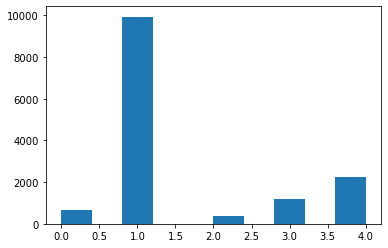

In [22]:
x=[]
for val in df.Location:
    if 'Base' in val:
        x.append(0)
    elif 'Feeder' in val:
        x.append(1)
    elif 'Left' in val:
        x.append(2)
    elif 'Right' in val:
        x.append(3)
    elif 'Tip' in val:
        x.append(4)
plt.hist(x)

In [105]:
df_old['locval']=x

In [17]:
np.unique(df.Mouse)

array([2001, 2003, 2005, 2021, 2023, 2027, 2031, 2039, 2043, 2049, 2065,
       2067, 2069, 2071, 2073, 2077], dtype=int64)

In [38]:
for val in np.unique(df.Mouse):
    plt.hist(df.locval[df.Mouse==val])
    plt.xlim(-.5,4.5)
    plt.xticks(ticks = [0,1,2,3,4], labels=np.unique(df.Location))
    plt.savefig('../../../{}_hist.png'.format(val))
    plt.close()

In [107]:
df=df_old[df_old.index<2456]
#df=df[df.index>806]

([<matplotlib.axis.XTick at 0x289faca9bb0>,
 [Text(0, 0, 'Base'),
  Text(1, 0, 'Feeder'),
  Text(2, 0, 'Left'),
  Text(3, 0, 'Right'),
  Text(4, 0, 'Tip')])

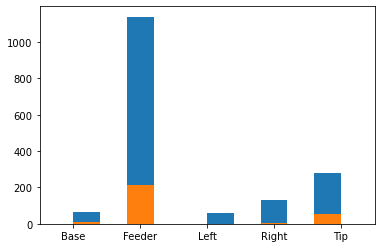

In [110]:
val=200
plt.hist(df_old.locval[df_old.Mouse==val])
plt.hist(df.locval[df.Mouse==val])
plt.xlim(-.5,4.5)
plt.xticks(ticks = [0,1,2,3,4], labels=np.unique(df_old.Location))

# TODO next
- make this have relative hours. This should help with later aligning events around midnight
- get timestamps from hut videos, make into csv
- align nearest timestamps, assuming some are lost on either side
- calculate concordance



- add Alec RFID from feeder
- get feeder cam timestamps
- align nearest timestamps, assuming some are lost on either side
- calculate concordance

# 2024 burrow SF data from curt loggers

In [14]:
listoffiles=[]
fld='/home/dennislab2/Desktop/burrowdata'
for folder in os.listdir(fld):
    if len(folder) > 2:
        folder_path = os.path.join(fld,folder)
        for file_name in os.listdir(folder_path):
            listoffiles.append(os.path.join(folder_path,file_name))
listoffiles.sort()
listoffiles[0:10]

['/home/dennislab2/Desktop/burrowdata/burrow5/000000000000-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000000634-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000001558-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000001956-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000005119-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000005536-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000010331-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000010843-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000011641-DATA-0005.txt',
 '/home/dennislab2/Desktop/burrowdata/burrow5/000000012636-DATA-0005.txt']

Index(['datetime', 'LOGGER_ID', 'WIRELESS_ID', 'motion_det', 'tempC', 'hum%',
       'AMP1ADC', 'AMP2ADC', 'batV_L', 'batV_NL', 'int-tempC', 'Tag_ID',
       'Pdir', 'Err', 'ext-tempC', 'Line', 'Comment'],
      dtype='object')

In [102]:
df=pd.DataFrame(columns=['datetime', 'LOGGER_ID', 'WIRELESS_ID', 'motion_det', 'tempC', 'hum%',
       'AMP1ADC', 'AMP2ADC', 'batV_L', 'batV_NL', 'int-tempC', 'Tag_ID',
       'Pdir', 'Err', 'ext-tempC', 'Line', 'Comment'])
for file in listoffiles:
    if 'config' not in file:
        txtascsv=pd.read_csv(file,sep=',',header=[1])
        if txtascsv.columns[0]=='datetime':
            onlytags = txtascsv[(txtascsv.Tag_ID.astype(str) !='nan') & (txtascsv.Tag_ID.astype(str) !='-99.0')].reset_index(drop=True)
            df=pd.concat([df,onlytags]).reset_index(drop=True)
            
dt=df.datetime.str.split(' ',expand=True)
dt.columns=['date','time']
dt['relday']=dt.date.str.split('/',expand=True)[0].astype(int)
dt['relmo']=dt.date.str.split('/',expand=True)[1].astype(int)
dt[['hr','mins','sec']]=dt.time.str.split(':',expand=True).astype(int)
if np.max(dt.relmo)!=0:
    for i in np.arange(0,len(np.unique(dt.relmo))-1):
        uniquemo=np.unique(dt.relmo)[i]
        maxday=np.max(dt.relday[dt.relmo==uniquemo])+1
        dt.relday[tst.relmo==np.unique(tst.relmo)[i+1]]+=maxday
df['reltime_hrs']=(dt.relday*24)+(dt.hr)+(dt.mins/60)+(dt.sec/3600)

/tmp/ipykernel_2446259/2048103807.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df=pd.concat([df,onlytags]).reset_index(drop=True)


(-1.0, 14.8)

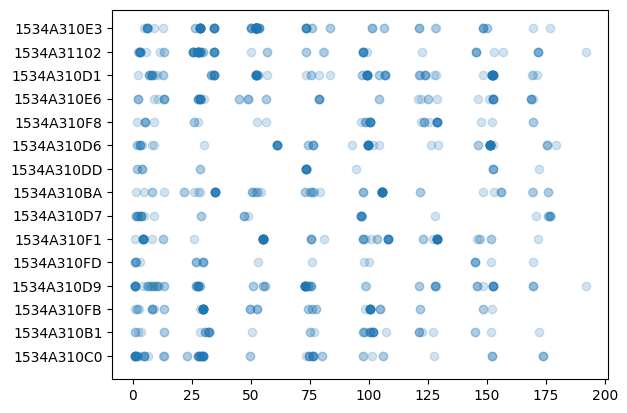

In [109]:
plt.scatter(df.reltime_hrs,df.Tag_ID,alpha=.2)
plt.ylim(-1,14.8)

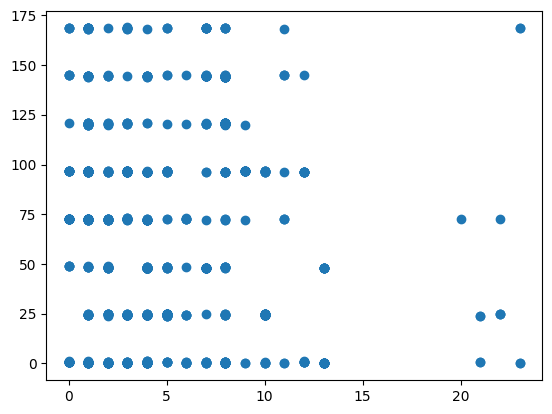

In [82]:
if np.max(tst.relmo)!=0:
    for i in np.arange(0,len(np.unique(tst.relmo))-1):
        uniquemo=np.unique(tst.relmo)[i]
        maxday=np.max(tst.relday[tst.relmo==uniquemo])+1
        tst.relday[tst.relmo==np.unique(tst.relmo)[i+1]]+=maxday

/tmp/ipykernel_2446259/1100910455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst.relday[tst.relmo==np.unique(tst.relmo)[i+1]]+=maxday


,date,time,relday,relmo,hr,min,sec
0,00/00/00,00:47:11,0,0,0,47,11
1,00/00/00,00:47:22,0,0,0,47,22
2,00/00/00,00:47:23,0,0,0,47,23
3,00/00/00,00:48:30,0,0,0,48,30
4,00/00/00,00:48:33,0,0,0,48,33
5,00/00/00,00:57:28,0,0,0,57,28
6,00/00/00,00:57:38,0,0,0,57,38
7,00/00/00,00:57:39,0,0,0,57,39
8,00/00/00,00:57:41,28,0,0,57,41
9,00/00/00,00:57:46,28,1,0,57,46


In [65]:
df.to_csv('/home/dennislab2/Desktop/burrow5_tagsonly.csv')

In [59]:
df.columns

17

In [111]:
def get_curt_data(folder_path):
    '''
    input a folder of txt files from a curt lamberth logger, and output a df with only tags\
    '''
    if not os.path.isdir(folder_path):
        print('you entered {} which is not a valid folder path')
    else:
        listoffiles=[]
        for file_name in os.listdir(folder_path):
            listoffiles.append(os.path.join(folder_path,file_name))
        listoffiles.sort()
        df=pd.DataFrame(columns=['datetime', 'LOGGER_ID', 'WIRELESS_ID', 'motion_det', 'tempC', 'hum%',
               'AMP1ADC', 'AMP2ADC', 'batV_L', 'batV_NL', 'int-tempC', 'Tag_ID',
               'Pdir', 'Err', 'ext-tempC', 'Line', 'Comment'])
        listoffiles = []
        for file in listoffiles:
            if 'config' not in file:
                print(file)
                txtascsv=pd.read_csv(file,sep=',',header=[1])
                if txtascsv.columns[0]=='datetime':
                    onlytags = txtascsv[(txtascsv.Tag_ID.astype(str) !='nan') & (txtascsv.Tag_ID.astype(str) !='-99.0')].reset_index(drop=True)
                    df=pd.concat([df,onlytags]).reset_index(drop=True)

        dt=df.datetime.str.split(' ',expand=True)
        dt.columns=['date','time']
        dt['relday']=dt.date.str.split('/',expand=True)[0].astype(int)
        dt['relmo']=dt.date.str.split('/',expand=True)[1].astype(int)
        dt[['hr','mins','sec']]=dt.time.str.split(':',expand=True).astype(int)
        if np.max(dt.relmo)!=0:
            for i in np.arange(0,len(np.unique(dt.relmo))-1):
                uniquemo=np.unique(dt.relmo)[i]
                maxday=np.max(dt.relday[dt.relmo==uniquemo])+1
                dt.relday[tst.relmo==np.unique(tst.relmo)[i+1]]+=maxday
        df['reltime_hrs']=(dt.relday*24)+(dt.hr)+(dt.mins/60)+(dt.sec/3600)
        return df